In [417]:
#AnalyticalModel  - Purpose: calculate pressures based on Jaz flow videos. do geometric optimization. 
#CKH Dec 10 2016 - No CFD, combines Anderson and Idol 1985 paper with
#the local zeta potential and surface velocity using the method of Wu and Li (2008)
#Wu, Zhemin, and Dongqing Li. "Mixing and flow regulating by induced-charge electrokinetic flow in a microchannel with a pair of conducting triangle hurdles." Microfluidics and nanofluidics 5.1 (2008): 65-76.
#CKH MAY 1 2017 I am revisiting this. At last we have flow rate data for more than two pore sizes. 
#CKH AGAIN I came back to this in JUNE 2017. Organized a lot of the data for Fig 4 and need to see where it lands.
#Got rid of the nondimensionalized plots and am specifically tracking the 3 sample types used in the experiments,
#none of which had equal thickness, pore spacing, pore diameter or metal coating length. Wish I could find a way
#to collapse them onto a single plot vs something.

In [418]:
#Something about units here
#Maxwell will export units in the column labels. Check below for a list of the column labels.
epsilon =80.0*8.854e-12 #dielectric constant of water in F/m
eta=8.9e-4 #dynamic viscosity of water in Pa*s

zetaPolymer=-0.02#zeta potential of the bare polymer membrane in volts
#It will depend on what the surrounding solution is
#I used -20 mV for polycarbonate at low concentration (pC near 0) and medium pH around 7
#From fig 2b in Electrophoresis (2004) 25, 203–213
#http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.559.3862&rep=rep1&type=pdf

In [419]:
#imports
import numpy as np

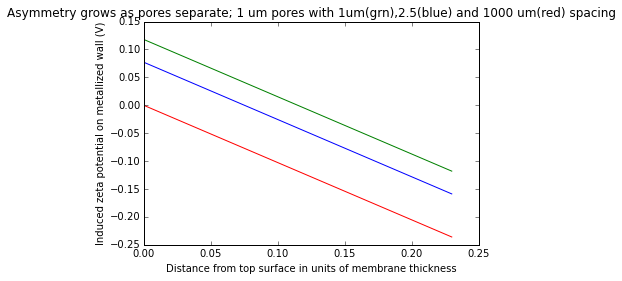

In [420]:
#The Maxwell results and CFD results showed 2 things
#1. The voltage drop is pretty much linear along the pore
#2. The velocity vectors along the top of the membrane are really small and don't contribute much;
#we didn't see any vortices or anything from those

#Use the CFD solution to produce images and use this analytical model to iterate quickly over different settings
#for the pore width, metal coating depth, membrane thickness and pore separation.

#To get the tangential velocity profile, have to calc the zeta potential along the contour.
#In Wu's paper, the induced zeta potential is Phi-sub-c - Phi-sub-e, where
#Phi-sub-c (Phic) is the spatial average of the external voltage Phi-sub-e over the metal surface, 
#Phi-sub-e is the external voltage which looks pretty much like transmembrane voltage * z/length

#I made a formula for Phic specific to the tube and flange, and made it nondimensionalized in 12/9/16 lab book
#Settings for 0.4 micron diameter pore we used
Vt04=1.165#trans-membrane voltage in volts, for 0.4 micron starts at 0 at the metal side
lm04=1.0e-6 #Length of metal section of pore in meters
lp04=10.0e-6 #Membrane thickness in meters
rp04=0.2e-6 #Pore radius in meters
rf04=0.56e-6 #Radius of Flange in meters This average ratio for pores with 12.5 percent open area.

#Settings for 1 micron diameter pore we used
Vt1=1.026 #1.04 from TransMembrane Voltage calculator after determining value of Vt04 that matches data
lm1=2.53e-6 #Length of Metal in meters
lp1=11.0e-6 #length of pore in meters
rp1=0.5e-6 #pore radius in meters
rf1=1.26e-6 #flange radius in meters

#Settings for 3 micron diameter pore we used
Vt3=0.928 #from TransMembrane Voltage Calc. A smaller voltage drop across more/bigger pores
lm3=2.53e-6 #7.47e-6 #Length of metal in meters, we need to measure it.
lp3=9.0e-6 #Length of pore in meters
rp3=1.5e-6 #radius of pore in meters
rf3=3.975e-6 #radius of flange in meters #sqrt (1e8 microns^2/pore numberdensity/pi)

def phicalc(Vti,lmi,lpi,rpi,rfi):
    phic=Vti*lmi/lpi/(rpi/lmi*((rfi/rpi)**2-1)+2)
    return phic

phic1=phicalc(Vt1,lm1,lp1,rp1,rf1)
phicSinglePore=phicalc(Vt1,lm1,lp1,rp1,1000)#try a bigger flange radius to pore radius, effectively entire tube is one sign
phicTube=phicalc(Vt1,lm1,lp1,rp1,rp1)#symmetric case, equal flange and tube

def zetapot(zl,phic,Vt):
    zeta=phic-Vt*zl
    return zeta

zl=np.linspace(0,lm1/lp1,50) #relative lengths along the pore
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(zl,zetapot(zl,phic1,Vt1))#Your blue line is going to be somewhere between the two lines
plt.hold('true')
plt.plot(zl,zetapot(zl,phicSinglePore,Vt1),'r') #Pretty much maxes out at some large flange size, would be interesting to plot
plt.plot(zl,zetapot(zl,phicTube,Vt1),'g') #Here the tubes have no space between them. This case should be symmetric
plt.ylabel('Induced zeta potential on metallized wall (V)')
plt.xlabel('Distance from top surface in units of membrane thickness')
plt.title('Asymmetry grows as pores separate; 1 um pores with 1um(grn),2.5(blue) and 1000 um(red) spacing')

In [421]:
#Keep in mind the Helmholtz-Smoluchowski expression is hardly valid 
#for voltages > a few dozen mV
etang04=-Vt04/lp04
etang1=-Vt1/lp1
etang3=-Vt3/lp3

def AvgZetaPos(lmi,lpi,rpi,rfi,Vti,zp):
    phi_c=phicalc(Vti,lmi,lpi,rpi,rfi)
    return lmi/lpi*(zetapot(0,phi_c,Vti)+zetapot(lmi/lpi,phi_c,Vti))/2 +(1-lmi/lpi)*zp #Average zeta potential within the tube when voltage is pos

def AvgZetaNeg(lmi,lpi,rpi,rfi,Vti,zp):
    phi_c=phicalc(Vti,lmi,lpi,rpi,rfi)
    return lmi/lpi*(zetapot(0,-phi_c,-Vti)+zetapot(lmi/lpi,-phi_c,-Vti))/2+(1-lmi/lpi)*zp #Avg zeta potential within tube when voltage is neg
#Anderson & Idol 1985, says velocity is given by AVERAGE zeta potential in a capillary if it's non-uniform, an amazing result

#Check a few values are not >> 26 mV
AvgZetaPos(lm1,lp1,rp1,rf1,Vt1,zetaPolymer),AvgZetaNeg(lm1,lp1,rp1,rf1,Vt1,zetaPolymer)


(-0.024785507167235495, -0.006014492832764505)

In [422]:
#Going to use these functions to calculate flow rates

def avgUPositive (lmi,lpi,rpi,rfi,Vti,zp,etangi):#calculate a single avgUPositive for a set of variables
    return -epsilon*AvgZetaPos(lmi,lpi,rpi,rfi,Vti,zp)*etangi/eta

def avgUNegative(lmi,lpi,rpi,rfi,Vti,zp,etangi):#calculate a single avgUNegative for a set of variables
    return -epsilon*AvgZetaNeg(lmi,lpi,rpi,rfi,Vti,zp)*etangi/eta

def avgWallVel(lmi,lpi,rpi,rfi,Vti,zp,etangi): #Time averaged wall velocity in m/s
    return (avgUPositive(lmi,lpi,rpi,rfi,Vti,zp,-etangi)+avgUNegative(lmi,lpi,rpi,rfi,Vti,zp,etangi))/2



In [423]:
#Now want to know pressure drop for this amount of flow. Use Hagen-Poiseuille pipe flow equation 
#Equate Janus ICEO pump paper equations 5 and 6  -- but use Jaz's video flow rate measurement for Eq 5
#Then solve equation 6 for delta-P, which is the max pressure.
#Do we get in the 390 Pa range?
n04=1.0e8 #(Number of pores per cm2 for the 400 nm diameter pores)
n1=2.0e7  #For 1 micron diameter pores
n3=2.0e6 #For 3 micron diameter pores

#Observed open channel flow rates Qmax
qmax04=64*1e-9/60 #64 microliters per minute to cubic meters per second

#-----------------##
diskrad=.5 #exposed membrane radius in cm
N04=np.pi*diskrad**2*n04 #total number of pores in the 0.4 micron diameter pore membranes
N1=np.pi*diskrad**2*n1 #total number of pores in the 1 micron diameter pore membrane
N3=np.pi*diskrad**2*n3 #total number of pores in the 3 micron diameter pore membrane

tubelength=0.2 #Silicone tube length in meters - Total length of silicone tubes leading to and exiting device
tuberadius=0.0005 #Silicone tube radius in meters, about 1mm inner diameter
#ignore the pressure drop in the 1cm wide acrylic thing leading up to the membrane, and the holey support.


def pressuredrop (plength,N,rp,tubelength,tuberadius,qmax):#pressure drop for a given flow rate
    pmax=qmax*8*eta*(plength/(N*np.pi*rp**4)+ tubelength/(np.pi*tuberadius**4)) #Hagen-Poiseuille flow
    #for a membrane with N pores in parallel, all in series with the silicone tube
    return pmax

pmax04=pressuredrop(lp04,N04,rp04,tubelength,tuberadius,qmax04)
pmax04  #ok it came out 200 Pa and we are measuring like 390 closed-ended, this is not bad match
#considering it may be working against a small pressure head


200.1110179521843

(129.9051484024372, 515.7187579797435, 1284.884207337336)

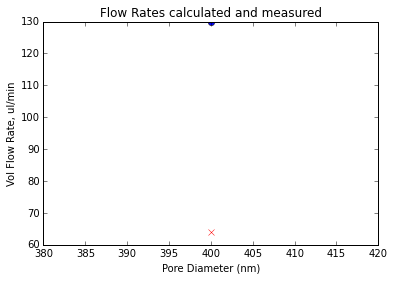

In [424]:
#Volumetric Flow Rates 
def FlowRate(Ni,lmi,lpi,rpi,rfi,Vti,zp):#calculate plug flow through all pores at 0 pressure drop
    etang=-Vti/lpi
    return(Ni*np.pi*(rpi)**2*avgWallVel(lmi,lpi,rpi,rfi,Vti,zp,etang)) *1e9*60 #In microliters/min
calcRate04=FlowRate(N04,lm04,lp04,rp04,rf04,Vt04,zetaPolymer) #Calc flow rate for 400 nm
calcRate1=FlowRate(N1,lm1,lp1,rp1,rf1,Vt1,zetaPolymer) #Calc flow rate for 1 micron
calcRate3=FlowRate(N3,lm3,lp3,rp3,rf3,Vt3,zetaPolymer) #Calc flow rate for 3 micron

plt.plot(400,calcRate04,'bo') #this curve was scaled to map onto exptl data with one fitting parameter, voltage
plt.xlabel('Pore Diameter (nm)')
plt.ylabel('Vol Flow Rate, ul/min')
plt.hold('true')
plt.plot(400,64,'rx')#experimental data for 400 nm pores-- ckh check again
#would it match with a 2nd or 3rd data point though?
plt.title('Flow Rates calculated and measured')
calcRate04, calcRate1,calcRate3

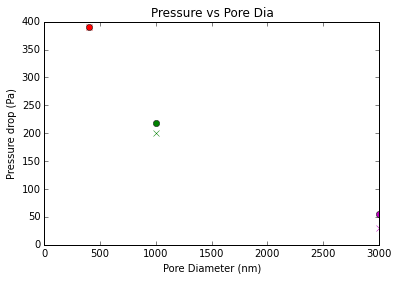

In [425]:
#Pressure at 0 flow rate is the pressure that drives equal backflow through a pore
pressure04=8.0*eta*calcRate04/(1e9*60*N04)*lp04/(np.pi*(rp04)**4) 
pressure1=8.0*eta*calcRate1/(1e9*60*N1)*lp1/(np.pi*(rp1)**4) 
pressure3=8.0*eta*calcRate3/(1e9*60*N3)*lp3/(np.pi*(rp3)**4)


plt.xlabel('Pore Diameter (nm)')
plt.ylabel('Pressure drop (Pa)')
plt.hold('true')
plt.plot(400,390,'rx')
plt.plot(1000,200,'gx')#result at 1um but that was for vt=1.02V
plt.plot(3000,30,'mx')#result at 3um but for 0.933V
plt.plot(400,pressure04,'ro')
plt.plot(1000,pressure1,'go')#result at 1um but that was for vt=1.02V
plt.plot(3000,pressure3,'mo')#result at 3um but for 0.933V

plt.title('Pressure vs Pore Dia')

#A peak voltage of 170 Volts was applied to the electrodes, but the 400 nm results fit a value of 133V
#(about a 20% reduction). Voltage drops across the solution led to a trans-membrane voltage of 1.165V 
#for the 400 nm pore diameter.
#A similar effect was reported by the McGrath group at Rochester. The voltage across the pore is likely to be lower than advertised 
#because ion crowding increases the solution conductivity near the walls.

#Using this reduced value for the applied voltage, this model predicts a pressure drop of 220 Pa for the 1 micron pores
#close to the measured value of  (Green dot) Add error bars...
#Howver, it overpredicts the 3 micron pressure drop.
#Could the problem be the assumption the metal coating on the sidewalls always goes 4 radii into the pore?
#When I say the 1 and 3 micron pores have the same metal coating depth, the 3 micron result is closer to the measured value.
#Is there a sputtering model? Can we measure how deep the metal coating goes?

In [426]:
#Try to fit the pressure vs voltage plot for three different pore sizes, each with its own conditions